# LSTM
参考：http://rf00.hatenablog.com/entry/2018/02/10/180018

In [1]:
import numpy as np
import pandas as pd

# グラフ描画
from matplotlib import pylab as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [2]:
# 正弦波
data = np.sin(np.array([i for i in range(120)])/99 * 4 * 2 * np.pi)
ws = 10

In [3]:
from sklearn.preprocessing import MinMaxScaler

#正規化
sclr = MinMaxScaler(feature_range=(0, 1))
data = sclr.fit_transform(data.reshape(-1, 1))

In [4]:
# データ変換
def convert(X, ws = 1, dim = 1):
    data = []
    target = []
    
    for i in range(ws, len(X)):
        data.append(X[i - ws : i])
        target.append(X[i])
        
    # データの整形
    data = np.array(data).reshape(len(data), ws, dim)
    target = np.array(target).reshape(-1,1)
        
    return data, target

In [5]:
#変換
X_d_c, y_d_c = convert(data, ws, 1)

In [6]:
print(X_d_c.shape)
print(y_d_c.shape)

(110, 10, 1)
(110, 1)


In [7]:
### データの分割
from sklearn.model_selection import train_test_split

X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(X_d_c, y_d_c, test_size = 0.3, shuffle = False)

In [8]:
print(X_train_c.shape, X_val_c.shape, y_train_c.shape, y_val_c.shape)

(77, 10, 1) (33, 10, 1) (77, 1) (33, 1)


dense挟む意味あるの？って思ったけど、あるっぽい。  
statefulはTrueで次のバッチ処理に隠れ状態を継承する。普通は隠れ状態はバッチ処理単位で初期化(0)されるが、今回は時系列データでバッチ単位で完全に独立とは言えなさそうなのでTrueにしている。バッチサイズは1。ウィンドウサイズは10。  
return_sequenceとは、TrueにしてRNNレイヤーの毎時刻の出力を得るか、Falseにして最後の時刻のみの出力を得るか、のフラグのようです。デフォルトではFalseになっていて、最後の時刻のみの出力を得ます。RNNレイヤーを複数積み重ねたい時は、各時刻で層間のデータのやり取りがあるので、(少なくとも最後の層以外は)必ずTrueにしなければならないようです。


In [9]:
import keras
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.wrappers import Bidirectional

#モデル設定
main_input = Input(shape=(X_train_c.shape[1], X_train_c.shape[2]),
                   dtype='float32',
                   batch_shape = (1, X_train_c.shape[1], 1), 
                   name='main_input')

#out = LSTM(8, stateful = True, return_sequences = True, activation='tanh')(main_input)
#main_output = LSTM(1, stateful = True, activation='tanh')(main_input)
out = LSTM(8, stateful = True, return_sequences = True, activation='tanh')(main_input)
out = LSTM(16, stateful = True, activation='tanh')(main_input)
main_output = Dense(1, activation='linear', name='output')(out)

model = Model(inputs=[main_input], outputs=[main_output])
model.compile(loss="mse", optimizer=Adam())

Using TensorFlow backend.


In [10]:
#学習
batch_size = 1
n_epoch = 100

log_loss = np.zeros(n_epoch)
log_val_loss = np.zeros(n_epoch)
models = []


for i in range(n_epoch):
    res = model.fit(X_train_c, y_train_c, batch_size = batch_size, 
          epochs = 1, validation_data=(X_val_c, y_val_c), verbose = 1, shuffle = False)
    
    #ロスを保存
    log_loss[i] = res.history['loss'][0]
    log_val_loss[i] = res.history['val_loss'][0]
    models.append(res)
    
    model.reset_states() #毎回stateをリセット

Train on 77 samples, validate on 33 samples
Epoch 1/1
77/77 [==============================] - 1s 17ms/step - loss: 0.2036 - val_loss: 0.1333
Train on 77 samples, validate on 33 samples
Epoch 1/1
77/77 [==============================] - 0s 5ms/step - loss: 0.1264 - val_loss: 0.1136
Train on 77 samples, validate on 33 samples
Epoch 1/1
77/77 [==============================] - 0s 6ms/step - loss: 0.1065 - val_loss: 0.1005
Train on 77 samples, validate on 33 samples
Epoch 1/1
77/77 [==============================] - 0s 5ms/step - loss: 0.0919 - val_loss: 0.0859
Train on 77 samples, validate on 33 samples
Epoch 1/1
77/77 [==============================] - 0s 5ms/step - loss: 0.0744 - val_loss: 0.0607
Train on 77 samples, validate on 33 samples
Epoch 1/1
77/77 [==============================] - 0s 5ms/step - loss: 0.0509 - val_loss: 0.0376
Train on 77 samples, validate on 33 samples
Epoch 1/1
77/77 [==============================] - 0s 5ms/step - loss: 0.0272 - val_loss: 0.0122
Train on 77 

77/77 [==============================] - 0s 5ms/step - loss: 5.6295e-04 - val_loss: 5.2918e-04
Train on 77 samples, validate on 33 samples
Epoch 1/1
77/77 [==============================] - 0s 5ms/step - loss: 6.9892e-04 - val_loss: 1.3481e-04
Train on 77 samples, validate on 33 samples
Epoch 1/1
77/77 [==============================] - 0s 5ms/step - loss: 5.5838e-04 - val_loss: 6.0812e-04
Train on 77 samples, validate on 33 samples
Epoch 1/1
77/77 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 9.8263e-04
Train on 77 samples, validate on 33 samples
Epoch 1/1
77/77 [==============================] - 0s 6ms/step - loss: 8.7192e-04 - val_loss: 1.1541e-04
Train on 77 samples, validate on 33 samples
Epoch 1/1
77/77 [==============================] - 1s 7ms/step - loss: 6.6860e-04 - val_loss: 4.9296e-04
Train on 77 samples, validate on 33 samples
Epoch 1/1
77/77 [==============================] - 0s 5ms/step - loss: 5.5554e-04 - val_loss: 1.0925e-04
Train on 77 sam

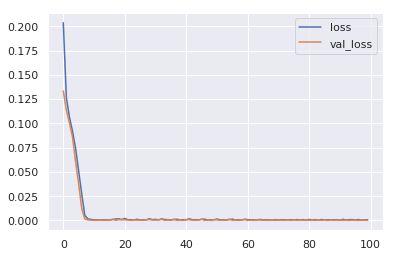

In [11]:
import pandas as pd
loss_df = pd.DataFrame([log_loss, log_val_loss]).T
loss_df.columns = ["loss", "val_loss"]
loss_df.plot()

In [12]:
print(np.argsort(log_val_loss)[0])
print(np.argsort(log_loss)[0])
best_model = models[np.argsort(log_val_loss)[0]].model

48
90


In [13]:
#各予測に予測結果を使う
def pred_pred_data(model, X, X_val):
    model.reset_states()

    length = len(X_val)
    prediction_train = np.zeros(len(X))
    prediction = np.zeros(length)
        
    #train分まず予測する
    for i in range(len(X)):
        prediction_train[i] = model.predict(X[i].reshape(1,-1,1))[0]
    
    tmp = X[len(X) - 1, :, :].reshape(1,-1,1)#学習データの最後の値から予測していく
    
    #特定期間さきまで予測
    for i in range(length):
        prediction[i] = model.predict(tmp)[0]
        
        #次に予測に使うデータを更新
        tmp = tmp[0, 1:, 0]
        tmp = np.append(tmp, prediction[i]).reshape(1,-1,1)
        #tmp = prediction[i].reshape(1,-1,1)
    
    model.reset_states()
    
    return np.hstack((prediction_train, prediction))

(110,) (110,)


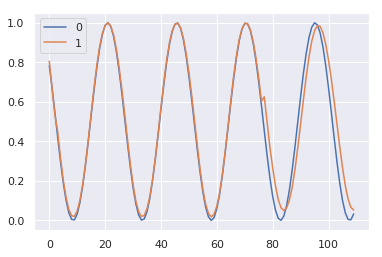

In [14]:
#予測結果で予測
pred2 = pred_pred_data(best_model, X_train_c, X_val_c)
res2 = data[ws:].reshape(-1)
print(res2.shape, pred2.shape)
pd.DataFrame(np.vstack((res2, pred2)).T).plot()